In [64]:
from tqdm.auto import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F

from transformers import AutoModelForCausalLM, AutoTokenizer
from datasets import load_dataset

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
model = AutoModelForCausalLM.from_pretrained('roneneldan/TinyStories-33M', cache_dir="data/").to(device)
tokenizer = AutoTokenizer.from_pretrained("EleutherAI/gpt-neo-125M", cache_dir="data/")

In [4]:
dataset = load_dataset("roneneldan/TinyStories", split="validation", cache_dir="data/")

Using custom data configuration roneneldan--TinyStories-72d66bdf5cbe9a95
Found cached dataset parquet (/net/vast-storage/scratch/vast/tegmark/ericjm/the-everything-machine/tinystories/data/roneneldan___parquet/roneneldan--TinyStories-72d66bdf5cbe9a95/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)


In [5]:
lens = [len(tokenizer.encode(dataset[i]['text'])) for i in range(len(dataset))]
print(np.argmax(lens))
print(max(lens))

6475
1075


In [6]:
def tokenize_sample(sample):
    tokens = tokenizer(sample["text"], return_tensors='pt', max_length=2048, truncation=True)["input_ids"]
    return {"input_ids": tokens}

dataset = dataset.map(tokenize_sample)
dataset = dataset.map(lambda sample: {"split_by_token": tokenizer.batch_decode(sample["input_ids"][0])})
dataset = dataset.map(lambda sample: {"tokens_len": len(sample["input_ids"][0])})
dataset = dataset.map(lambda sample: {"preds_len": max(sample["tokens_len"] - 1, 0)}) # fixed this on 2023-02-06 to accomodate empty documents
starting_indexes = np.array([0] + list(np.cumsum(dataset["preds_len"])))

def loss_idx_to_dataset_idx(idx):
    """given an idx in range(0, 10658635), return
    a sample index in range(0, 20000) and pred-in-sample
    index in range(0, 1023). Note token-in-sample idx is
    exactly pred-in-sample + 1"""
    sample_index = np.searchsorted(starting_indexes, idx, side="right") - 1
    pred_in_sample_index = idx - starting_indexes[sample_index]
    return int(sample_index), int(pred_in_sample_index)

def get_context(idx):
    """given idx in range(0, 10658635), return dataset sample
    and predicted token index within sample, in range(1, 1024)."""
    sample_index, pred_index = loss_idx_to_dataset_idx(idx)
    return dataset[sample_index], pred_index+1

def print_context(idx):
    """
    given idx in range(0, 10658635), print prompt preceding the corresponding
    prediction, and highlight the predicted token.
    """
    sample, token_idx = get_context(idx)
    prompt = sample["split_by_token"][:token_idx]
    prompt = "".join(prompt)
    token = sample["split_by_token"][token_idx]
    print(prompt + "\033[41m" + token + "\033[0m")


  0%|          | 0/21990 [00:00<?, ?ex/s]

  0%|          | 0/21990 [00:00<?, ?ex/s]

  0%|          | 0/21990 [00:00<?, ?ex/s]

  0%|          | 0/21990 [00:00<?, ?ex/s]

In [60]:
dataset.save_to_disk("data/tinystories_tokenized")

Saving the dataset (0/1 shards):   0%|          | 0/21990 [00:00<?, ? examples/s]

In [53]:
losses = []
for i in tqdm(range(len(dataset))):
    text = dataset[i]['text']
    if text:
        # this should be the same as dataset[i]['input_ids']
        tokens = tokenizer(text, return_tensors='pt', max_length=2048, truncation=True).to(device) 
        logits = model(**tokens).logits
        targets = tokens.input_ids
        ls = F.cross_entropy(logits[0, :-1, :], targets[0, 1:], reduction='none')
        losses.append(ls.tolist())
    else:
        losses.append([])

  0%|          | 0/21990 [00:00<?, ?it/s]

In [54]:
sum([len(x) for x in losses])

4721938

In [57]:
sum([dataset[i]['preds_len'] for i in range(len(dataset))])

4721938

In [59]:
total_length = sum(len(x) for x in losses)

results_arr = torch.zeros(total_length, dtype=torch.float32)
j = 0
for x in tqdm(losses, desc="Flattening results"):
    results_arr[j:j+len(x)] = torch.tensor(x, dtype=torch.float32)
    j += len(x)

torch.save(results_arr, "data/losses.pt")

Flattening results:   0%|          | 0/21990 [00:00<?, ?it/s]

In [61]:
losses = torch.load("data/losses.pt")

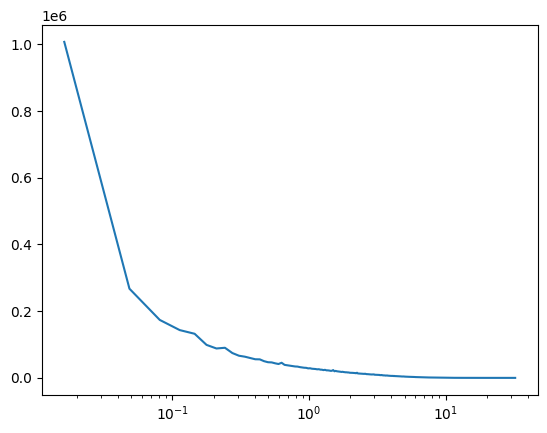

In [72]:
# compute histogram over losses array
hist, bin_edges = np.histogram(losses, bins=1000)
centers = (bin_edges[:-1] + bin_edges[1:]) / 2
plt.plot(centers, hist)
plt.xscale('log')
# plt.yscale('log')

In [75]:
lowloss_idxs = (losses < 0.2).nonzero().flatten().tolist()

In [96]:
print_context(lowloss_idxs[843])

Once upon a time, there was a little boy named Tim. Tim had a big, orange ball. He loved his ball


In [97]:
param_names = [n for n, _ in model.named_parameters()]

In [102]:
highsignal_names = [name for name in param_names if 
                        ('ln' not in name) and 
                        ('wte' not in name) and
                        ('wpe' not in name)]

In [104]:
def get_flattened_gradient(model, param_subset):
    grads = []
    for name, p in model.named_parameters():
        if name in param_subset:
            grads.append(p.grad)
    return torch.cat([g.flatten() for g in grads])

In [105]:
text = dataset[0]['text']
# this should be the same as dataset[i]['input_ids']
tokens = tokenizer(text, return_tensors='pt', max_length=2048, truncation=True).to(device) 
logits = model(**tokens).logits
targets = tokens.input_ids
ls = F.cross_entropy(logits[0, :-1, :], targets[0, 1:], reduction='none')
ls[8]

tensor(0.0506, device='cuda:0', grad_fn=<SelectBackward0>)

In [107]:
ls[8].backward()

In [108]:
g = get_flattened_gradient(model, highsignal_names)

In [109]:
len(g)

28329984

In [111]:
token_idxs = lowloss_idxs[::100][:10000]

In [112]:
len_g = sum(model.state_dict()[name].numel() for name in highsignal_names)
S = len(token_idxs)

In [114]:
block_len = 250
blocks = [token_idxs[i:min(len(token_idxs), i+block_len)] for i in range(0, len(token_idxs), block_len)]

In [117]:
C = torch.zeros((S, S), device=device)

In [131]:
print_context(token_idxs[0])

Spot. Spot saw the shiny car and said,


In [132]:
doc, l = get_context(token_idxs[0])

In [ ]:
iouter = 0
for iblock in tqdm(blocks, desc="outer loop"):
    Gi = torch.zeros((len(iblock), len_g), device=device)
    for i, idx in enumerate(iblock):
        model.zero_grad()
        document, l = get_context(idx)
        prompt = document['text']
        tokens = tokenizer(prompt, return_tensors='pt', max_length=1024, truncation=True).to(device)
        logits = model(**tokens).logits
        targets = tokens.input_ids
        ls = torch.nn.functional.cross_entropy(logits[0, :-1, :], targets[0, 1:], reduction='none')
        ls_l = ls[l-1]
        ls_l.backward()
        g = get_flattened_gradient(model, highsignal_names)
        # g = torch.cat([g, g.abs()])
        Gi[i] = g
    Gi = F.normalize(Gi, p=2, dim=1)
    # Gi = Gi - Gi.mean(dim=1, keepdim=True)
    j_index = blocks.index(iblock)
    jouter = sum(len(block) for block in blocks[:j_index])
    for jblock in tqdm(blocks[j_index:], leave=False, desc="inner loop"):
        Gj = torch.zeros((len(jblock), len_g), device=device)
        for j, idx in enumerate(jblock):
            model.zero_grad()
            document, l = get_context(idx)
            prompt = document['text']
            tokens = tokenizer(prompt, return_tensors='pt', max_length=1024, truncation=True).to(device)
            logits = model(**tokens).logits
            targets = tokens.input_ids
            ls = torch.nn.functional.cross_entropy(logits[0, :-1, :], targets[0, 1:], reduction='none')
            ls_l = ls[l-1]
            ls_l.backward()
            g = get_flattened_gradient(model, highsignal_names)
            # g = torch.cat([g, g.abs()])
            Gj[j] = g
        Gj = F.normalize(Gj, p=2, dim=1)
        # Gj = Gj - Gj.mean(dim=1, keepdim=True)
        Cij = torch.matmul(Gi, Gj.T)
        C[iouter:iouter+len(iblock), jouter:jouter+len(jblock)] = Cij
        C[jouter:jouter+len(jblock), iouter:iouter+len(iblock)] = Cij.T
        jouter += len(jblock)
    iouter += len(iblock)

In [137]:
torch.save(C, "data/C-0.pt")

In [11]:
i = 16
print(tokenizer.decode(tokens.input_ids[0][:i]))
tokenizer.decode(y.logits[0][i-1].argmax().item())

Spot. Spot saw the shiny car and said, "Wow, Kitty, your


' car'

In [12]:
len(data)

21990